# Pytorch dataset creation

> pytorch dataset will be created here

In [ ]:
#| default_exp dataloader_creation

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| export
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from typing import List, Callable, Tuple, Dict, Union
from pathlib import Path
from fastcore.all import *
import cv2

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#| export
def get_transforms(*, data):
    if data == 'train':
        return A.Compose([
            #A.Resize(256, 256),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.Transpose(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
            #A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            #A.Normalize(mean=[0, 0, 0], std=[1/255, 1/255, 1/255]),
            A.Normalize(mean=[0], std=[1/255]),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            #A.Resize(256, 256),
            A.Normalize(mean=[0], std=[1/255]),
            #A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

In [ ]:
#| export
class SegmentationDataset(Dataset):
    def __init__(
                self, 
                image_path:Union[Path, str], 
                mask_path:Union[Path, str], 
                exts:str,
                transform=None
                ):
        self.image_path = image_path
        self.mask_path = mask_path
        # getting images and masks
        self.images = Path(self.image_path).ls(file_exts=exts)
        self.masks = Path(self.mask_path).ls(file_exts=exts)

        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = np.array(Image.open(f"{self.images[idx]}").convert("L")).astype(dtype=np.float32)
        mask = np.array(Image.open(f"{self.masks[idx]}").convert("L"))
        mask = (mask> 0).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        #image = image[None, ...]
        mask = mask[None, ...]

        return image, mask

In [ ]:
Path.cwd()

Path('/home/hasan/workspace/git_data/segmentation_test/nbs')

In [ ]:

im_path= Path(r'/home/hasan/workspace/data/microscopy_data/patch_images/')
msk_path = Path(r'/home/hasan/workspace/data/microscopy_data/patch_masks/')


In [ ]:
dataset = SegmentationDataset(
    image_path=im_path,
    mask_path=msk_path,
    exts='.png',
    )


In [ ]:
TRAIN_SPLIT=0.8

In [ ]:
train_len = int(TRAIN_SPLIT *len(dataset))
val_len = len(dataset) - train_len
train_len, val_len

(1313, 329)

In [ ]:
train_dataset, val_dataset = random_split(
    dataset,
    lengths=[train_len, val_len]
)

In [ ]:
img, msk=train_dataset[0]

In [ ]:
img.shape, msk.shape

((256, 256), (1, 256, 256))

In [ ]:
len(train_dataset), len(val_dataset)

(1313, 329)

In [ ]:
#| export
def create_pytorch_dataloader(
    split_type:str, # in case of 'random' randomly data will be splitted
    split_per:float, # percentage of training data
    batch_size:int,
    image_path:Union[Path, str],
    mask_path:Union[Path, str],
    transforms:Callable, # a callable function named as [get_transform] with argument data='train' or 'valid'
    exts:str='.png',  # image  and mask data extensions
    num_workers:str=4
   ):

    'Create pytorch dataloader based on the argument'

    dataset = SegmentationDataset(
                                image_path=image_path,
                                mask_path=mask_path,
                                exts=exts
                              )

    print(f' Number of images found = {len(dataset)}')
    if split_type == 'random':
        train_len = int(split_per * len(dataset))
        val_len = len(dataset) - train_len

        train_ds, val_ds = random_split(dataset, lengths=[train_len, val_len])
        print(f' training dataset length = {len(train_ds)} and validation dataset length=  {len(val_ds)}')
        

        if transforms is not None:
            train_ds.dataset.transform = transforms(data='train')
            val_ds.dataset.transform = transforms(data='valid')
        else:
            train_ds.dataset.transform = get_transforms(data='train')
            val_ds.dataset.transform = get_transforms(data='valid')
            print(train_ds[0][0].shape, val_ds[0][0].shape)

        train_dl = DataLoader(
                              train_ds, 
                              batch_size=batch_size,
                              shuffle=True, 
                              num_workers=num_workers, 
                              pin_memory=True
        )
        val_dl = DataLoader(
                              val_ds, 
                              batch_size=batch_size,
                              shuffle=True, 
                              num_workers=num_workers, 
                              pin_memory=True
        )

    else:
        raise NotImplementedError("Only random split is implemented")
    
    return train_dl, val_dl




In [ ]:
Path(im_path).ls(file_exts='.png')

(#1642) [Path('/home/hasan/workspace/data/microscopy_data/patch_images/img_147_p_7.png'),Path('/home/hasan/workspace/data/microscopy_data/patch_images/img_51_p_10.png'),Path('/home/hasan/workspace/data/microscopy_data/patch_images/img_164_p_1.png'),Path('/home/hasan/workspace/data/microscopy_data/patch_images/img_122_p_4.png'),Path('/home/hasan/workspace/data/microscopy_data/patch_images/img_134_p_1.png'),Path('/home/hasan/workspace/data/microscopy_data/patch_images/img_80_p_2.png'),Path('/home/hasan/workspace/data/microscopy_data/patch_images/img_77_p_8.png'),Path('/home/hasan/workspace/data/microscopy_data/patch_images/img_47_p_7.png'),Path('/home/hasan/workspace/data/microscopy_data/patch_images/img_78_p_10.png'),Path('/home/hasan/workspace/data/microscopy_data/patch_images/img_83_p_2.png')...]

In [ ]:
train_dl, val_dl = create_pytorch_dataloader(
    split_type='random',
    split_per=0.8,
    batch_size=2,
    image_path=im_path,
    mask_path=msk_path,
    transforms=get_transforms,
    num_workers=0

)

 Number of images found = 1642
 training dataset length = 1313 and validation dataset length=  329


In [ ]:
img, msk = next(iter(train_dl))

In [ ]:
img.shape, msk.shape

(torch.Size([2, 1, 256, 256]), torch.Size([2, 1, 256, 256]))

In [ ]:
#| export
def visualize_batch(images, masks, num_images=4):
    fig, axs = plt.subplots(1,num_images, figsize=(5, num_images*5))
    for idx, (image, mask) in enumerate(zip(images, masks)):
        if idx >= num_images:
            break
        axs[idx].imshow(image.squeeze(0).squeeze(0), cmap='gray')
        axs[idx].imshow(mask.squeeze(), cmap='jet', alpha=0.3)  # overlay mask on image
        axs[idx].axis('off')
        axs[idx].set_title('Image with Mask')
    plt.tight_layout()
    plt.show()

In [ ]:
images, masks = next(iter(train_dl))
images.shape

torch.Size([2, 1, 256, 256])

In [ ]:
n_img = images[0]

n_img.squeeze(0).shape

torch.Size([256, 256])

In [ ]:
n_img.shape

torch.Size([1, 256, 256])

In [ ]:
images.shape, masks.shape

(torch.Size([2, 1, 256, 256]), torch.Size([2, 1, 256, 256]))

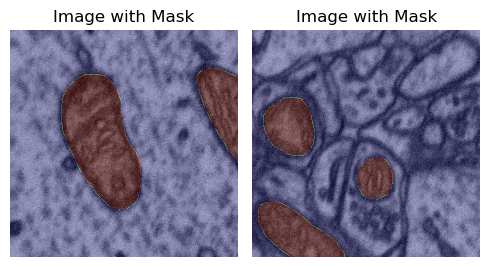

In [ ]:
visualize_batch(images=images, masks=masks, num_images=2)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export('09_dataset_creation.ipynb')